<a href="https://colab.research.google.com/github/Fallen37/Example_web/blob/main/Skin_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("ismailpromus/skin-diseases-image-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'skin-diseases-image-dataset' dataset.
Path to dataset files: /kaggle/input/skin-diseases-image-dataset


In [ ]:
import os
import shutil
import random

def filter_skin_disease_dataset(source_dir, dest_dir, selected_classes, images_per_class=1250):
    """
    Copies a subset of images from selected classes to a new directory.
    Args:
    - source_dir: Original dataset path.
    - dest_dir: Destination for filtered dataset.
    - selected_classes: List of 3 class names (folder names).
    - images_per_class: Number of images to copy per class.
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for class_name in selected_classes:
        class_source_path = os.path.join(source_dir, class_name)
        class_dest_path = os.path.join(dest_dir, class_name)

        if not os.path.exists(class_source_path):
            print(f"Class '{class_name}' not found in source directory.")
            continue

        os.makedirs(class_dest_path, exist_ok=True)

        images = os.listdir(class_source_path)
        random.shuffle(images)
        selected_images = images[:images_per_class]

        for image in selected_images:
            src_img = os.path.join(class_source_path, image)
            dst_img = os.path.join(class_dest_path, image)
            shutil.copyfile(src_img, dst_img)

        print(f"Copied {len(selected_images)} images for class '{class_name}'.")

# Example usage:
source_dataset_dir = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
filtered_dataset_dir = '/content/filtered_dataset'
user_selected_classes = ['3. Atopic Dermatitis - 1.25k', '1. Eczema 1677', '6. Benign Keratosis-like Lesions (BKL) 2624',
'9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k','8. Seborrheic Keratoses and other Benign Tumors - 1.8k']  # <-- user inputs this list

filter_skin_disease_dataset(source_dataset_dir, filtered_dataset_dir, user_selected_classes)

Copied 1250 images for class '3. Atopic Dermatitis - 1.25k'.
Copied 1250 images for class '1. Eczema 1677'.
Copied 1250 images for class '6. Benign Keratosis-like Lesions (BKL) 2624'.
Copied 1250 images for class '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k'.
Copied 1250 images for class '8. Seborrheic Keratoses and other Benign Tumors - 1.8k'.


In [ ]:
import os
import shutil
import random

def split_dataset(filtered_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for split in ['train', 'val', 'test']:
        for class_name in os.listdir(filtered_dir):
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

    for class_name in os.listdir(filtered_dir):
        class_path = os.path.join(filtered_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split_name, image_list in splits.items():
            for image in image_list:
                src = os.path.join(class_path, image)
                dst = os.path.join(output_dir, split_name, class_name, image)
                shutil.copyfile(src, dst)

        print(f"Class '{class_name}' split into {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test")

# Example usage:
filtered_dataset_dir = '/content/filtered_dataset'
split_output_dir = '/content/split_dataset'

split_dataset(filtered_dataset_dir, split_output_dir)

Class '1. Eczema 1677' split into 875 train, 187 val, 188 test
Class '8. Seborrheic Keratoses and other Benign Tumors - 1.8k' split into 875 train, 187 val, 188 test
Class '3. Atopic Dermatitis - 1.25k' split into 875 train, 187 val, 188 test
Class '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k' split into 875 train, 187 val, 188 test
Class '6. Benign Keratosis-like Lesions (BKL) 2624' split into 875 train, 187 val, 188 test


In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
import cv2
import numpy as np
import random

# Custom preprocessing function for blurring and random noise
def custom_augment(image):
    # Convert float32 [0,1] to uint8 [0,255]
    img = (image * 255).astype(np.uint8)

    # Random Gaussian blur
    if random.random() < 0.3:  # 30% chance
        ksize = random.choice([3, 5])  # kernel size
        img = cv2.GaussianBlur(img, (ksize, ksize), 0)

    # Random brightness adjustment
    if random.random() < 0.3:
        factor = random.uniform(0.7, 1.3)
        img = np.clip(img * factor, 0, 255)

    # Random contrast adjustment
    if random.random() < 0.3:
        alpha = random.uniform(0.8, 1.2)
        beta = random.randint(-20, 20)
        img = np.clip(alpha * img + beta, 0, 255)

    # Convert back to float32 [0,1]
    return img.astype(np.float32) / 255.0


# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
base_dir = '/content/split_dataset'

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    preprocessing_function=custom_augment   # Apply our custom blur/contrast/brightness
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4375 images belonging to 5 classes.
Found 935 images belonging to 5 classes.
Found 940 images belonging to 5 classes.


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

data = datagen.flow_from_directory(
    '/content/filtered_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # because ML models want labels as integers
    shuffle=True
)

Found 6250 images belonging to 5 classes.


In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import AUC
inputs = Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Save this layer as feature output
feature_output = x

output = layers.Dense(train_generator.num_classes, activation='softmax')(feature_output)

model = models.Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 651,173 (2.48 MB)

 Trainable params: 650,213 (2.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
print("Dimensions of the feature output layer:", feature_output.shape)

Dimensions of the feature output layer: (None, 256)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_auc',  # or 'val_loss'
    patience=20,
    mode='max',         # 'min' for val_loss
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='max',
    min_lr=1e-6
)

model.fit(train_generator, validation_data=val_generator,epochs=150)  # Only 5-10 epochs needed for feature learning
# Save the model in HDF5 (.h5) format



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 130s 751ms/step - accuracy: 0.1953 - auc: 0.4992 - loss: 1.8875 - val_accuracy: 0.1989 - val_auc: 0.4867 - val_loss: 1.6928
Epoch 2/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 81s 588ms/step - accuracy: 0.2062 - auc: 0.5188 - loss: 1.6200 - val_accuracy: 0.2000 - val_auc: 0.5076 - val_loss: 9.9959
Epoch 3/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 79s 576ms/step - accuracy: 0.2096 - auc: 0.5193 - loss: 1.6086 - val_accuracy: 0.2000 - val_auc: 0.4990 - val_loss: 28.0247
Epoch 4/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 79s 577ms/step - accuracy: 0.2223 - auc: 0.5313 - loss: 1.6030 - val_accuracy: 0.2000 - val_auc: 0.4998 - val_loss: 94.2144
Epoch 5/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 79s 572ms/step - accuracy: 0.2257 - auc: 0.5426 - loss: 1.6062 - val_accuracy: 0.2000 - val_auc: 0.4969 - val_loss: 189.2145
Epoch 6/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 80s 580ms/step - accuracy: 0.2439 - auc: 0.5487 - loss: 1.6007 - val_accuracy: 0.2000 - val_auc: 0.5000 - val_loss: 219.0911
Epoch 7/1

KeyboardInterrupt: 

In [ ]:
model.save('skin_disease_classifier5.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step
CNN MODEL ARCHITECTURE
Accuracy:  0.8787
Precision: 0.8831
Recall:    0.8787
F1-score:  0.8779

Classification Report:
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.92      0.79      0.85       188
                                    3. Atopic Dermatitis - 1.25k       0.84      0.91      0.88       188
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.94      1.00      0.97       188
          8. Seborrheic Keratoses and other Benign Tumors - 1.8k       0.93      0.80      0.86       188
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k       0.80      0.89      0.84       188

                                                        accuracy                           0.88       940
                                                       macro avg       0.88      0.88      0.88  

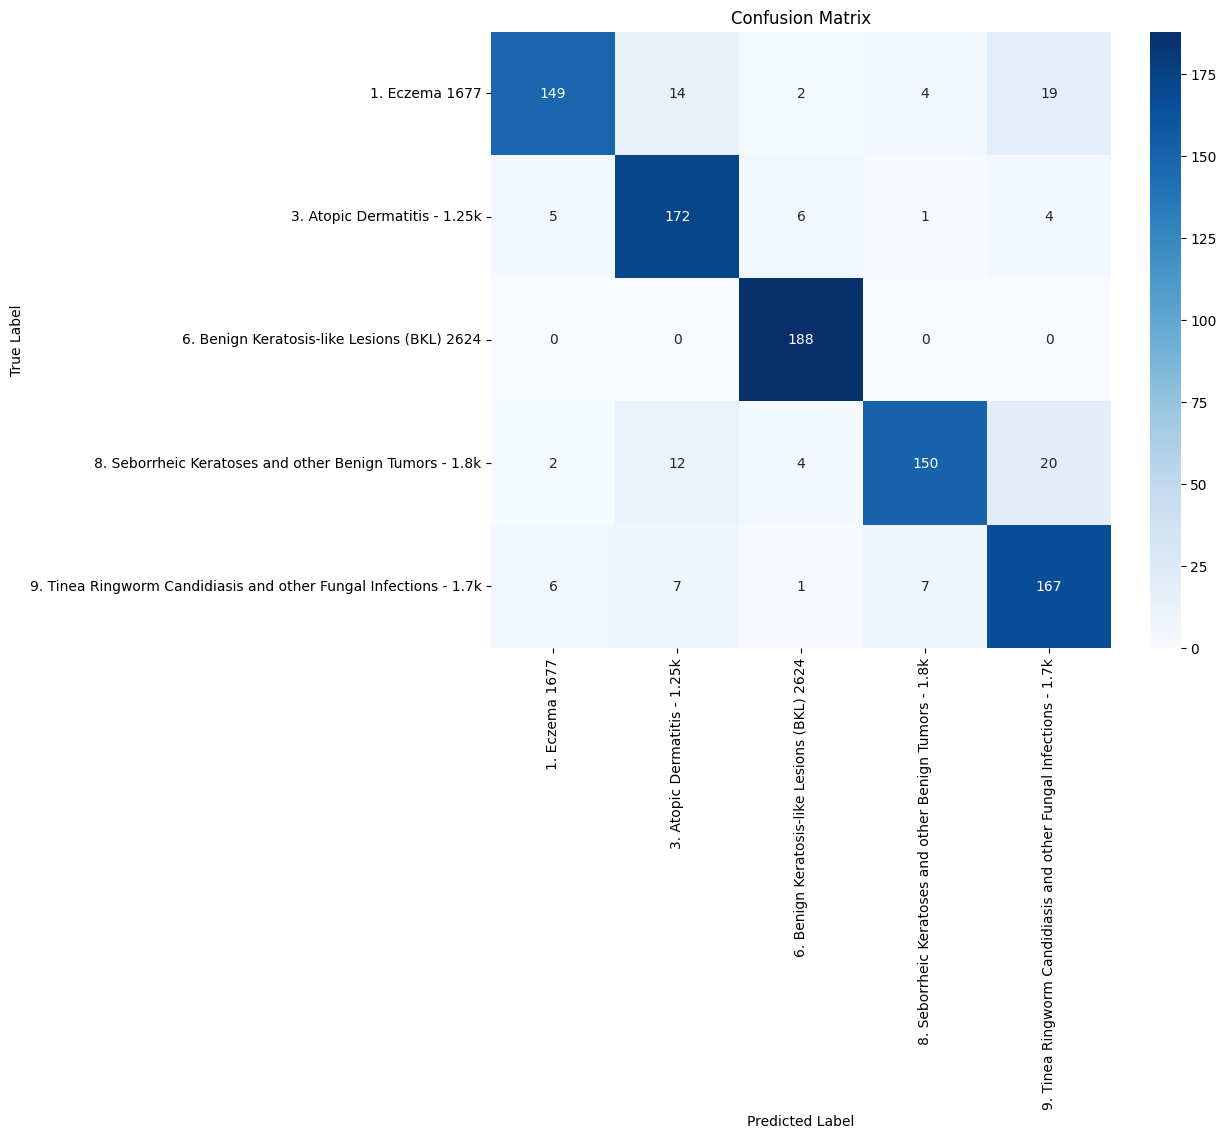

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

model_path = "/root/.cache/kagglehub/datasets/ismailpromus/skin-diseases-image-dataset/versions/skin_disease_classifier2.h5"
model=load_model(model_path)

# Predict probabilities
y_pred_probs = model.predict(test_generator)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("CNN MODEL ARCHITECTURE")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("skin_disease_classifier5.keras", save_format="keras")

from google.colab import files
files.download('skin_disease_classifier5.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('skin_disease_classifier5.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import Model

# This will now work
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)


In [ ]:
from google.colab import files
feature_extractor.save("cnn_feature_extractor_model5.keras")
#files.download('cnn_feature_extractor_model4.keras')

In [ ]:
from tensorflow.keras.models import Model
from google.colab import files


# Build the feature extractor (if not already defined)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Save to HDF5 format
feature_extractor.save('cnn_feature_extractor_model5.h5')

# Download the model to your local machine (only works in Google Colab)
#files.download('cnn_feature_extractor_model5.h5')


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

model_path="/content/cnn_feature_extractor_model2.h5"
feature_extractor=load_model(model_path)

# We need shuffle=False to match features and labels correctly
datagen_noshuffle = ImageDataGenerator(rescale=1./255)
data_noshuffle = datagen_noshuffle.flow_from_directory(
    '/content/filtered_dataset',
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

features = feature_extractor.predict(data_noshuffle)
labels = data_noshuffle.classes


Found 6250 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 711s 4s/step


By SVM

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision :', precision_score(y_test, y_pred, average='weighted'))
print('Recall    :', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score : ', f1_score(y_test, y_pred, average='weighted'))
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


SVM
Accuracy: 0.8952
Precision : 0.8954366183023292
Recall    : 0.8952
F1 Score :  0.8950208892665723

Classification Report:
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.87      0.87      0.87       272
                                    3. Atopic Dermatitis - 1.25k       0.87      0.92      0.89       240
                     6. Benign Keratosis-like Lesions (BKL) 2624       1.00      1.00      1.00       254
          8. Seborrheic Keratoses and other Benign Tumors - 1.8k       0.85      0.85      0.85       255
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k       0.90      0.84      0.87       229

                                                        accuracy                           0.90      1250
                                                       macro avg       0.90      0.89      0.89      1250
                        

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming `features` is the CNN output (e.g., shape [num_samples, 256])
# and `labels` is the list or array of class labels
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=9
)


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression")
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Recall : ", recall_score(y_test, y_pred_logreg, average='weighted'))
print("Precision : ", precision_score(y_test, y_pred_logreg, average='weighted'))
print("F1 Score : ", f1_score(y_test, y_pred_logreg, average='weighted'))
print("\nClassification Report\n")
print(classification_report(y_test, y_pred_logreg))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_logreg))

import joblib

# Save logistic regression model
#joblib.dump(logreg, 'logistic_regression_model.pkl')  # ← saved with .h5 extension

from google.colab import files
#files.download('logistic_regression_model.pkl')



Logistic Regression
Logistic Regression Accuracy: 0.8944
Recall :  0.8944
Precision :  0.8947491108843547
F1 Score :  0.8941776599289084

Classification Report

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       228
           1       0.89      0.91      0.90       247
           2       1.00      1.00      1.00       252
           3       0.85      0.84      0.85       257
           4       0.89      0.83      0.86       266

    accuracy                           0.89      1250
   macro avg       0.89      0.90      0.89      1250
weighted avg       0.89      0.89      0.89      1250

Confusion Matrix:
 [[204  10   0   8   6]
 [ 10 226   1   7   3]
 [  0   0 251   1   0]
 [ 10  11   0 217  19]
 [ 17   8   0  21 220]]


By Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest")
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Recall : ", recall_score(y_test, y_pred_rf, average='weighted'))
print("Precision : ", precision_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score : ", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report\n")
print(classification_report(y_test, y_pred_rf))

Random Forest
Random Forest Accuracy: 0.8896
Recall :  0.8896
Precision :  0.8898570816944704
F1 Score :  0.8892533309619172

Classification Report

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       228
           1       0.86      0.92      0.89       247
           2       1.00      1.00      1.00       252
           3       0.86      0.84      0.85       257
           4       0.88      0.82      0.85       266

    accuracy                           0.89      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.89      0.89      0.89      1250



By KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
print("KNN")
print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Recall : ", recall_score(y_test, y_pred_knn, average='weighted'))
print("Precision : ", precision_score(y_test, y_pred_knn, average='weighted'))
print("F1 Score : ", f1_score(y_test, y_pred_knn, average='weighted'))
print("\nClassification Report\n")
print(classification_report(y_test, y_pred_knn))

KNN
K-Nearest Neighbors Accuracy: 0.8648
Recall :  0.8648
Precision :  0.8660430819808543
F1 Score :  0.8645957001259746

Classification Report

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       228
           1       0.84      0.86      0.85       247
           2       1.00      1.00      1.00       252
           3       0.84      0.81      0.83       257
           4       0.86      0.79      0.82       266

    accuracy                           0.86      1250
   macro avg       0.86      0.87      0.86      1250
weighted avg       0.87      0.86      0.86      1250



In [ ]:
Ensemble of random forest, logistic regression, KNN and SVM

SyntaxError: invalid syntax (ipython-input-2519566783.py, line 1)

In [ ]:
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Define individual models
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
svm_linear = SVC(kernel='linear', probability=True)
knn = KNeighborsClassifier(n_neighbors=5)

# Create an ensemble using VotingClassifier (hard voting by default)
ensemble_model = VotingClassifier(
    estimators=[
        ('LogReg', log_reg),
        ('RF', rf),
        ('SVM', svm_linear),
        ('KNN', knn)
    ],
    voting='soft'  # use 'soft' for probability averaging
)

# Train ensemble model
ensemble_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ensemble = ensemble_model.predict(X_test)
# Probabilities for AUC (only needed for binary or multilabel)
y_test_proba = ensemble_model.predict_proba(X_test)
print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_ensemble))
print("\n Classification Report:\n", classification_report(y_test, y_pred_ensemble))
try:
    if y_test_proba.shape[1] > 2:
        y_test_one_hot = np.eye(len(np.unique(y_test)))[y_test]
        auc_score = roc_auc_score(y_test_one_hot, y_test_proba, multi_class='ovr', average='weighted')
    else:
        auc_score = roc_auc_score(y_test, y_test_proba[:, 1])
    print(" AUC Score:", auc_score)
except Exception as e:
    print(" Could not compute AUC:", str(e))


Ensemble Model Accuracy: 0.908
Confusion Matrix:
 [[244  13   0   7   8]
 [ 11 222   0   5   2]
 [  0   0 254   0   0]
 [  7  16   1 217  14]
 [ 10   3   0  18 198]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       272
           1       0.87      0.93      0.90       240
           2       1.00      1.00      1.00       254
           3       0.88      0.85      0.86       255
           4       0.89      0.86      0.88       229

    accuracy                           0.91      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.91      0.91      0.91      1250

 Could not compute AUC: name 'roc_auc_score' is not defined


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import numpy as np

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Define individual models
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
svm_linear = SVC(kernel='linear', probability=True)
knn = KNeighborsClassifier(n_neighbors=5)

# Create the ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('LogReg', log_reg),
        ('RF', rf),
        ('SVM', svm_linear),
        ('KNN', knn)
    ],
    voting='soft'  # enables predict_proba for AUC
)

# Train the ensemble
ensemble_model.fit(X_train, y_train)

# Predictions
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# Probabilities for AUC (only needed for binary or multilabel)
y_test_proba = ensemble_model.predict_proba(X_test)

# Evaluation Metrics
print(" Training Accuracy:", accuracy_score(y_train, y_train_pred))
print(" Testing Accuracy :", accuracy_score(y_test, y_test_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\n Classification Report:\n", classification_report(y_test, y_test_pred))

# For multiclass: average='macro' or 'weighted'
print(" Precision:", precision_score(y_test, y_test_pred, average='weighted'))
print(" Recall   :", recall_score(y_test, y_test_pred, average='weighted'))
print(" F1 Score :", f1_score(y_test, y_test_pred, average='weighted'))

# AUC only works if you have probability predictions and more than one class
try:
    if y_test_proba.shape[1] > 2:
        y_test_one_hot = np.eye(len(np.unique(y_test)))[y_test]
        auc_score = roc_auc_score(y_test_one_hot, y_test_proba, multi_class='ovr', average='weighted')
    else:
        auc_score = roc_auc_score(y_test, y_test_proba[:, 1])
    print(" AUC Score:", auc_score)
except Exception as e:
    print(" Could not compute AUC:", str(e))


 Training Accuracy: 0.9676
 Testing Accuracy : 0.912

 Confusion Matrix:
 [[245  13   0   6   8]
 [ 11 226   0   3   0]
 [  0   0 254   0   0]
 [  7  15   1 217  15]
 [  9   3   0  19 198]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       272
           1       0.88      0.94      0.91       240
           2       1.00      1.00      1.00       254
           3       0.89      0.85      0.87       255
           4       0.90      0.86      0.88       229

    accuracy                           0.91      1250
   macro avg       0.91      0.91      0.91      1250
weighted avg       0.91      0.91      0.91      1250

 Precision: 0.91206325511827
 Recall   : 0.912
 F1 Score : 0.9117044800196068
 AUC Score: 0.9862177427635075


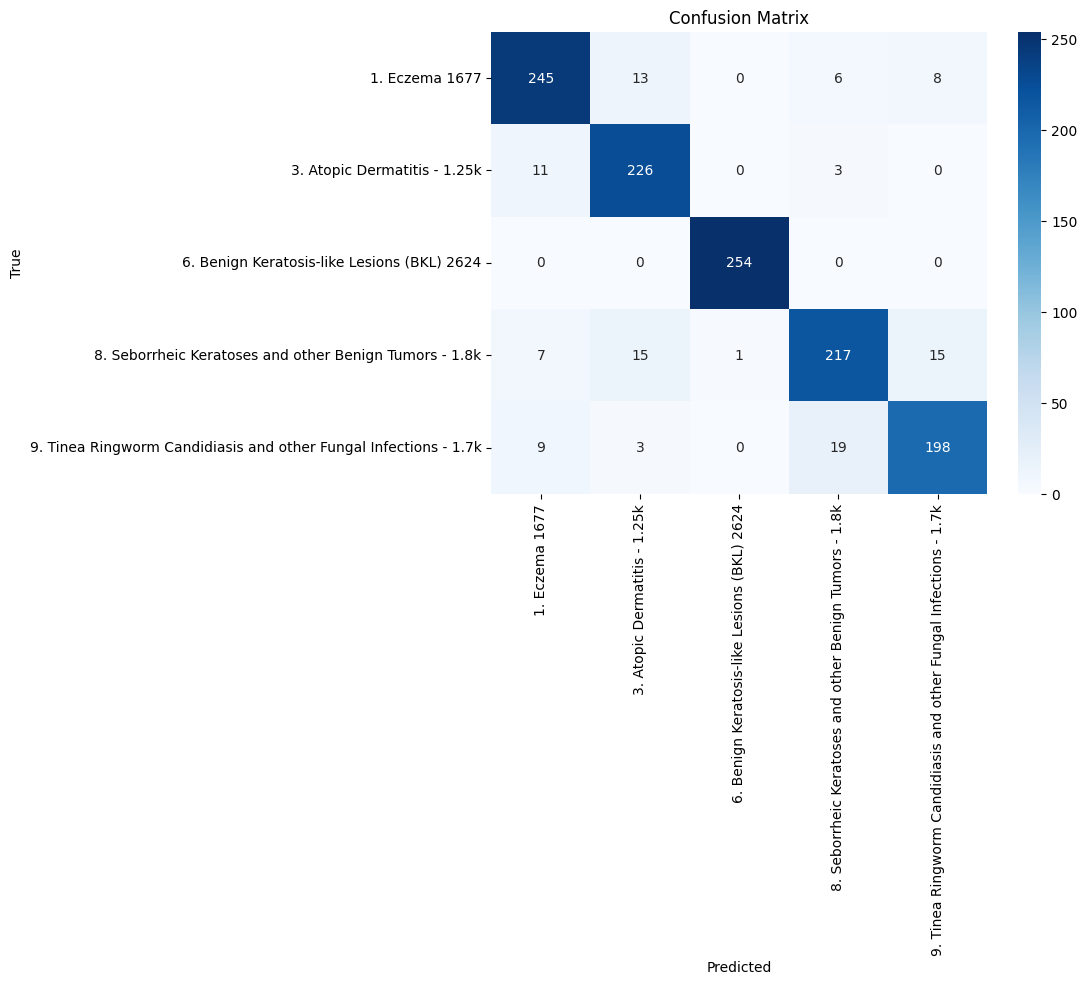

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
#Save ensemble model
joblib.dump(ensemble_model, 'ensemble_model3.pkl')  # ← saved with .h5 extension

from google.colab import files
files.download('ensemble_model3.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 4375 images belonging to 5 classes.
Found 935 images belonging to 5 classes.
Found 940 images belonging to 5 classes.
Class names: ['1. Eczema 1677', '3. Atopic Dermatitis - 1.25k', '6. Benign Keratosis-like Lesions (BKL) 2624', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step
 Training Accuracy: 0.9550
 Testing Accuracy: 0.9574

 Classification Report (Test Set):
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.94      0.96      0.95       188
                                    3. Atopic Dermatitis - 1.25k       0.95      0.97      0.96       188
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.99      1.00      1.00       188
          8. Seborrheic Keratoses and other Benign Tumors - 1.8k       0.95      0.94      0.94       188
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k       0.96      0.92      0.94       188

                                                        accuracy                           0.96       940
                                                       macro avg       0.96      0.96

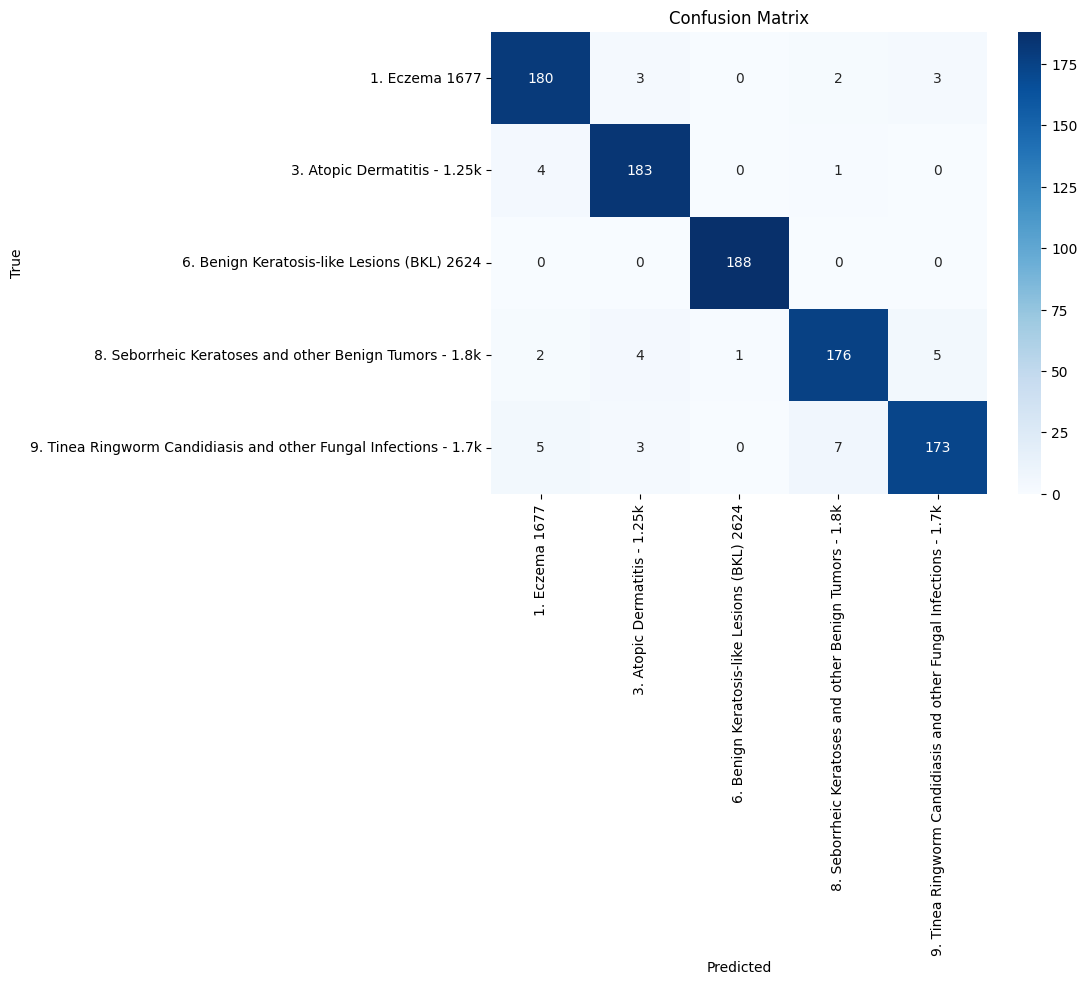

In [ ]:
#Evalution of ensemble model
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# --- 1. Load saved CNN feature extractor ---
cnn_feature_extractor = tf.keras.models.load_model(
    "/root/.cache/kagglehub/datasets/ismailpromus/skin-diseases-image-dataset/versions/cnn_feature_extractor_model2.h5",
    compile=False
)


# --- 2. Load your ensemble model (.pkl) ---
ensemble_model = joblib.load("/content/ensemble_model3.pkl")

# --- 3. Setup Data Generators ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
base_dir = '/content/split_dataset'

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Class names:", class_names)

# --- 4. Extract features using CNN ---
def extract_features(generator):
    features = cnn_feature_extractor.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

X_train, y_train = extract_features(train_gen)
X_test, y_test = extract_features(test_gen)

# --- 5. Predict using ensemble ---
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# --- 6. Accuracy ---
print(f" Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f" Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# --- 7. Classification Report ---
print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# --- 8. Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# --- AUC Calculation (One-vs-Rest for multi-class) ---
# Step 1: Binarize the true labels
y_test_bin = label_binarize(y_test, classes=list(range(len(class_names))))

# Step 2: Get predicted probabilities (ensure your ensemble supports predict_proba)
y_test_proba = ensemble_model.predict_proba(X_test)

# Step 3: Compute AUC Score (macro average)
auc_score = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr', average='macro')
print(f"AUC Score: {auc_score:.4f}")


AttributeError: This 'VotingClassifier' has no attribute 'predict_proba'

In [ ]:
try:
    if y_test_proba.shape[1] > 2:
        y_test_one_hot = np.eye(len(np.unique(y_test)))[y_test]
        auc_score = roc_auc_score(y_test_one_hot, y_test_proba, multi_class='ovr', average='weighted')
    else:
        auc_score = roc_auc_score(y_test, y_test_proba[:, 1])
    print(" AUC Score:", auc_score)
except Exception as e:
    print(" Could not compute AUC:", str(e))

 Could not compute AUC: Found input variables with inconsistent numbers of samples: [2854, 1565]


In [ ]:
import os
print(os.listdir("/content"))


['.config', 'split_dataset', 'cnn_feature_extractor_model2.keras', 'ensemble_model.pkl', 'filtered_dataset', 'sample_data']
